In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm
from model_settings import ms
pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name
from historical_av_plot_vol_surface import plot_vol_surface
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

                       spot_price               raw_data_key  \
0     /date_2024_10_11/spot_price  /date_2024_10_11/raw_data   
1     /date_2024_10_10/spot_price  /date_2024_10_10/raw_data   
2     /date_2024_10_09/spot_price  /date_2024_10_09/raw_data   
3     /date_2024_10_08/spot_price  /date_2024_10_08/raw_data   
4     /date_2024_10_07/spot_price  /date_2024_10_07/raw_data   
...                           ...                        ...   
4115  /date_2008_01_10/spot_price  /date_2008_01_08/raw_data   
4116  /date_2008_01_09/spot_price  /date_2008_01_07/raw_data   
4117  /date_2008_01_08/spot_price  /date_2008_01_04/raw_data   
4118  /date_2008_01_07/spot_price  /date_2008_01_03/raw_data   
4119  /date_2008_01_04/spot_price  /date_2008_01_02/raw_data   

                   surface_key  \
0     /date_2024_10_11/surface   
1     /date_2024_10_10/surface   
2  

# data

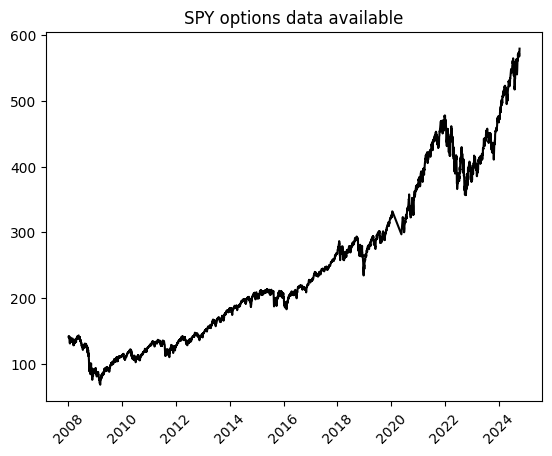

<Figure size 640x480 with 0 Axes>

In [2]:
spot_keys = keys_df.loc[:,['spot_price']].dropna()
spots = pd.Series()
store.open()
for i,row in spot_keys.iterrows():
    key = row['spot_price']
    date = key[key.find('_',0)+1:key.find('/',1)]
    spot_datetime = datetime.strptime(date,'%Y_%m_%d')
    spot_price = float(store[key].iloc[0])
    spots.loc[spot_datetime] = spot_price
store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# calibrations

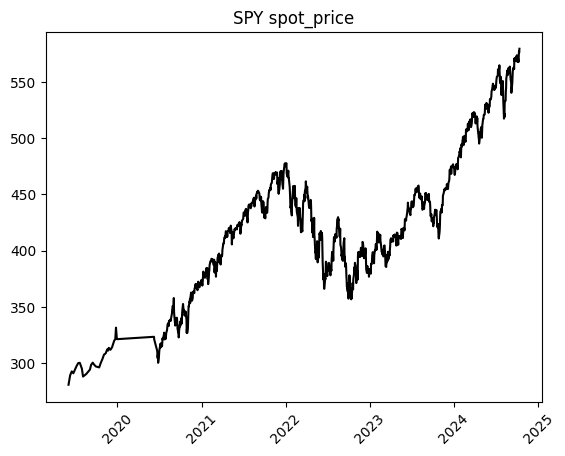

<Figure size 640x480 with 0 Axes>

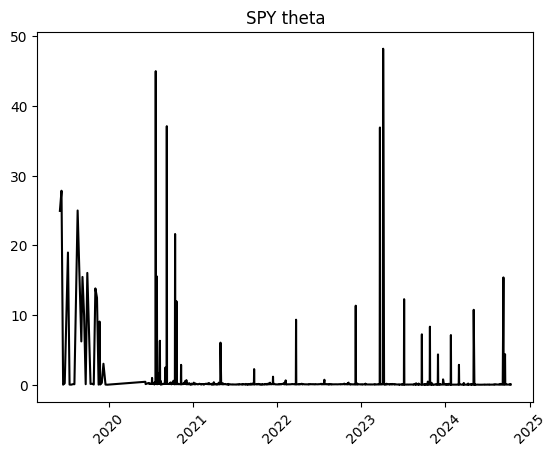

<Figure size 640x480 with 0 Axes>

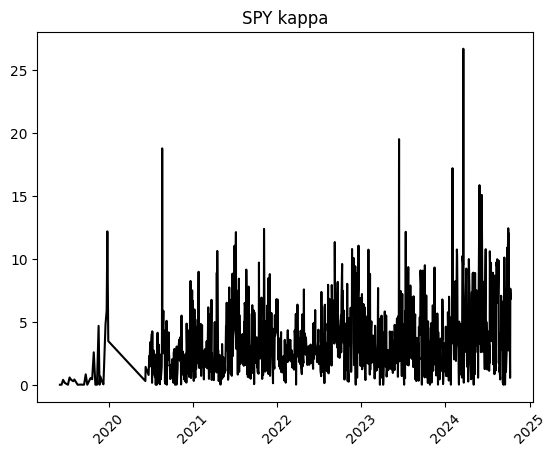

<Figure size 640x480 with 0 Axes>

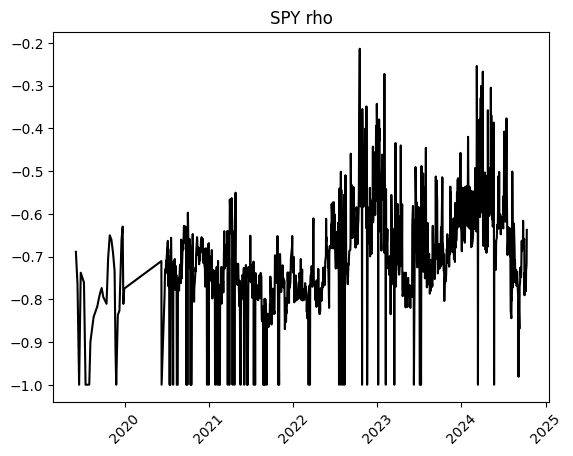

<Figure size 640x480 with 0 Axes>

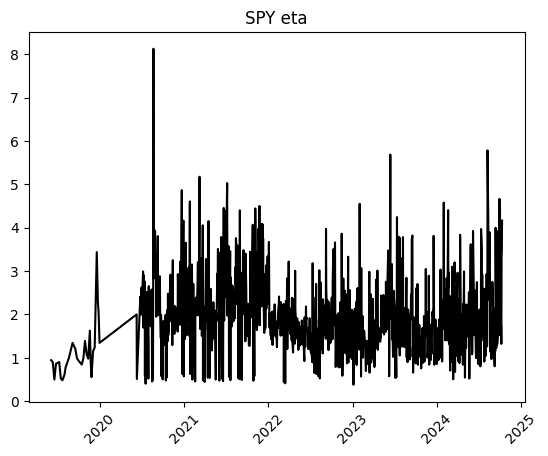

<Figure size 640x480 with 0 Axes>

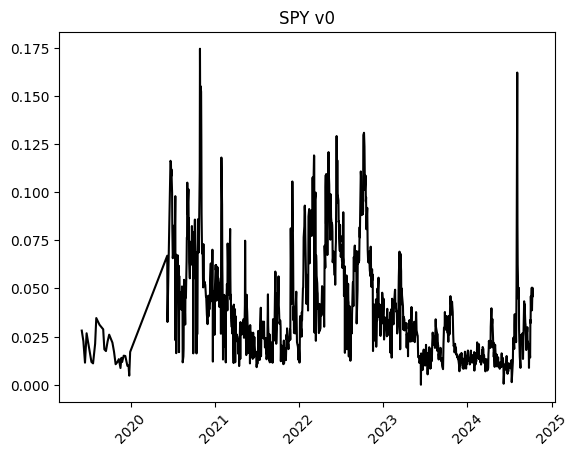


                    calculation_date   strike_price   market_price  \
count                        2773137 2773137.000000 2754344.000000   
mean   2022-07-07 04:07:16.231458816     398.720177      34.589223   
min              2019-06-03 00:00:00       5.000000       0.000000   
25%              2021-06-14 00:00:00     325.000000       0.490000   
50%              2022-05-27 00:00:00     400.000000       8.010000   
75%              2023-08-09 00:00:00     471.000000      42.770000   
max              2024-10-11 00:00:00    4898.000000     461.370000   
std                              NaN     117.047064      57.538640   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 2773137.000000    2773137.000000 2773137.000000  2773137.000000   
mean        0.269639        110.039942     429.300119        0.040000   
min         0.006110         30.000000     280.530000        0.040000   
25%         0.167240         50.000000     390.080000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [3]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            key = row['calibration_key']
            date = key[key.find('_',0)+1:key.find('/',1)].replace('_','-')
            calibrations.append(store[row['calibration_key']])
            parameters[date] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date').sort_index()
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

## calibration testing

### original recalibration

In [4]:
problem_parameter = 'v0'
problem_theshold = 2
problems = pd.Series(calibrations[problem_parameter][calibrations[problem_parameter]>problem_theshold].drop_duplicates().index).dt.strftime('/date_%Y_%m_%d/heston_calibration/calibration_results')
dfs = {}
with pd.HDFStore(h5_name) as store:
    for key in problems:
        dfs[key] = store[key]
store.close()
print('problem calibration(s):')
for i,dfk in enumerate(dfs.keys()):
    print(f"{i}     {dfk}")
problem_keys = keys_df[keys_df['calibration_key'].isin(problems)]

problem_idx = 0
with pd.HDFStore(h5_name) as store:
    calibration_key = problem_keys['calibration_key'].iloc[0]
    surface = store[problem_keys['surface_key'].iloc[problem_idx]].drop_duplicates()
    heston_parameters = store[problem_keys['parameter_key'].iloc[problem_idx]]
    calibration = store[problem_keys['calibration_key'].iloc[problem_idx]]
    raw_data = store[problem_keys['raw_data_key'].iloc[problem_idx]]
    problem_spot = float(store[problem_keys['spot_price'].iloc[problem_idx]].iloc[0])
    date = calibration_key[calibration_key.find('_',0)+1:calibration_key.find('/',1)].replace('_','-')
    
store.close()
print(date)
previous_avgabs = np.mean(np.abs(calibration['error']))
print("original calibration:")
plot_vol_surface(surface)
print(heston_parameters)
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year
)
printdate = str(calculation_datetime.strftime('%A, ')+str(calculation_date))
print(f"average absolute error: {round(previous_avgabs,2)}")
print(printdate)

problem calibration(s):


IndexError: single positional indexer is out-of-bounds

In [ ]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    spot = problem_spot
    df = raw_data.copy()
    df['volume'] = pd.to_numeric(df['volume'])
    df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
    df['strike'] = pd.to_numeric(df['strike'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['days_to_maturity'] = df['expiration'] - df['date']
    df['days_to_maturity'] = df['days_to_maturity'] // np.timedelta64(1, 'D')
    df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
    df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
    df = df[['strike','implied_volatility','days_to_maturity','volume','type']]
    df = df[df['volume']>0].copy()
    df['spot_price'] = spot
    df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
    df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
    df = df.rename(
        columns={
            'strike':'strike_price',
            'type':'w',
            'implied_volatility':'volatility'
        }
    )
    
    indexed = df.copy().set_index(['strike_price','days_to_maturity'])

    
    T = np.sort(df['days_to_maturity'].unique()).tolist()
    K = np.sort(df['strike_price'].unique()).tolist()
    raw_surface = pd.DataFrame(
        np.tile(np.nan,(len(K),len(T))),
        index = K,
        columns = T
    )

### automatic reconstruction of the volatility surface

### linearization of the volatility surface

In [ ]:
from sklearn.linear_model import LinearRegression
def linearize_vol_surface(surface):
    s = problem_spot
    K = np.array(surface.index)
    atm_idx = pd.Series(abs(K-s)).sort_values().index.tolist()[0]
    atm_vols = surface.iloc[atm_idx]
    T = np.array(surface.columns)
    
    derman_coefs = pd.Series(np.empty(len(T),dtype=float),index=T)
    for t in T:
        vols = surface.loc[:,t]
        x = np.array(vols.index)-s
        y = vols - atm_vols.loc[t]
        model = LinearRegression(fit_intercept=False)
        x = x.reshape(-1,1)
        model.fit(x,y)
        b = model.coef_[0]
        derman_coefs.loc[t] = b
    
    derman_surface = pd.DataFrame(
        np.empty((len(K),len(T)),dtype=float),
        index=K,
        columns=T
    )
    
    for k in K:
        moneyness = k-s
        for t in T:
            derman_surface.loc[k,t] = atm_vols.loc[t] + moneyness*derman_coefs.loc[t]
    
    plot_vol_surface(derman_surface)
    vol_matrix = derman_surface.copy()
    return vol_matrix

In [ ]:
vol_matrix = linearize_vol_surface(surface)

## manual recalibration

In [ ]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:

    vol_matrix = vol_matrix.sort_index().drop_duplicates()
    s = spot
    T = vol_matrix.columns.tolist()
    K = vol_matrix.index.tolist()
    r = 0.04
    g = 0.0
    
    ql.Settings.instance().evaluationDate = calculation_date
    flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    
    heston_helpers = []
    v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
    process = ql.HestonProcess(
        flat_ts,
        dividend_ts,
        S_handle,
        v0,                # Initial volatility
        kappa,             # Mean reversion speed
        theta,             # Long-run variance (volatility squared)
        eta,               # Volatility of the volatility
        rho                # Correlation between asset and volatility
    )
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    
    for t in T:
        for k in K:
            p = ql.Period(int(t),ql.Days)
            volatility = vol_matrix.loc[k,t]
            helper = ql.HestonModelHelper(
                p, ms.calendar, float(s), k, 
                ql.QuoteHandle(ql.SimpleQuote(volatility)), 
                flat_ts, 
                dividend_ts
                )
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
    
    lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    
    model.calibrate(heston_helpers, lm,
                      ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
    
    theta, kappa, eta, rho, v0 = model.params()
    heston_parameters = pd.Series(
        [theta, kappa, eta, rho, v0],
        index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
        dtype = float
    )
    calibration_test_data = df.copy()
    calibration_test_data['spot_price'] = s
    calibration_test_data['risk_free_rate'] = r
    calibration_test_data['dividend_rate'] = g
    calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
    calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
    calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
        calibration_test_data['spot_price'].values,
        calibration_test_data['strike_price'].values,
        calibration_test_data['w'].values
    )
    calibration_test_data['calculation_date'] = date
    calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
    calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
    calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
    avg = np.mean(np.abs(calibration_test_data['error']))

    print("recalibrated:")
    plot_vol_surface(vol_matrix)
    print(f"\n{printdate}\n{heston_parameters}\n\naverage absolute error: {round(avg,3)}")
    print(f"previous error: {round(previous_avgabs,3)}\nchange: {round(avg-previous_avgabs,4)}")
    print(f"\n\ncalibration testing dataset:\n{calibration_test_data.describe()}")
    print(f"\n{calibration_test_data.dtypes}")

### ENTRY REPLACEMENT

In [ ]:
def replace_calibration_data():
    results_replacement_key = problem_keys.iloc[problem_idx]['calibration_key']
    parameter_replacement_key = problem_keys.iloc[problem_idx]['parameter_key']
    surface_replacement_key = problem_keys.iloc[problem_idx]['surface_key']
    with pd.HDFStore(h5_name) as store:
        store.put(surface_replacement_key,vol_matrix,format='table',append=False)
        store.put(parameter_replacement_key,heston_parameters,format='table',append=False)
        store.put(results_replacement_key,calibration_test_data,format='table',append=False)
        print(f'{results_replacement_key} | {parameter_replacement_key} | {surface_replacement_key}:     replaced')
    store.close()
try:
    print(printdate)
except Exception:
    pass

In [ ]:
replace_calibration_data()